# [E-10] 프로젝트: 인물 모드 문제점 찾기

<br>

---

### 들어가며...

- 한국에서는 배경을 흐리게 하는 기술을 `아웃포커싱`이라고 한다. 하지만 실제로 정확한 용어는 **얕은 피사계 심도(shallow depth of field)** 또는 **셸로우 포커스(shallow focus)**라고 한다.

![image](https://user-images.githubusercontent.com/103712369/170423538-4bc22ca1-7ae9-4b74-a279-5737b23a024b.png)<br><br><br>
**<이미지 세그멘테이션을 이용한 인물사진 개념>**<br><br>

- 이미지 세그멘테이션(image segmentation) 기술을 사용하면 하나의 이미지에서 배경과 사람을 분리할 수 있다.<br>
- 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있다.

<br>

# Step1. 인물모드 직접 해보기

---


### 우선 먼저 필요한 Library 및 Package를 import하자

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

- `urllib` 웹에서 데이터를 다운로드할 때 사용
- `cv2` OpenCV 라이브러리로 이미지를 처리하기 위해 필요함.
- `pixellib`는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리

In [2]:
jay_img_path = os.getenv('HOME') + '/aiffel/human_segmentation/Ex_file/my_jay.jpg'
my_img_path = os.getenv('HOME') + '/aiffel/human_segmentation/Ex_file/mypic.png'
happydog_img_path = os.getenv('HOME') + '/aiffel/human_segmentation/Ex_file/happydog.png'
bed_img_path = os.getenv('HOME') + '/aiffel/human_segmentation/Ex_file/bed.jpg'

jay_img_orig = cv2.imread(jay_img_path)
my_img_orig = cv2.imread(my_img_path)
happydog_img_orig = cv2.imread(happydog_img_path)
bed_img_orig = cv2.imread(bed_img_path)
bed_img_orig = bed_img_orig[:1107, :886]

print('재이사진 사이즈 :', jay_img_orig.shape)
print('증명사진 사이즈 :', my_img_orig.shape)
print('강아지사진 사이즈 :', happydog_img_orig.shape)
print('침대사진 사이즈 :', bed_img_orig.shape)

재이사진 사이즈 : (4032, 3024, 3)
증명사진 사이즈 : (333, 249, 3)
강아지사진 사이즈 : (320, 320, 3)
침대사진 사이즈 : (1107, 886, 3)


#### OpenCV로 파일을 읽어와서 사진 파일 plt.imshow 기능을 통해 불러온다.

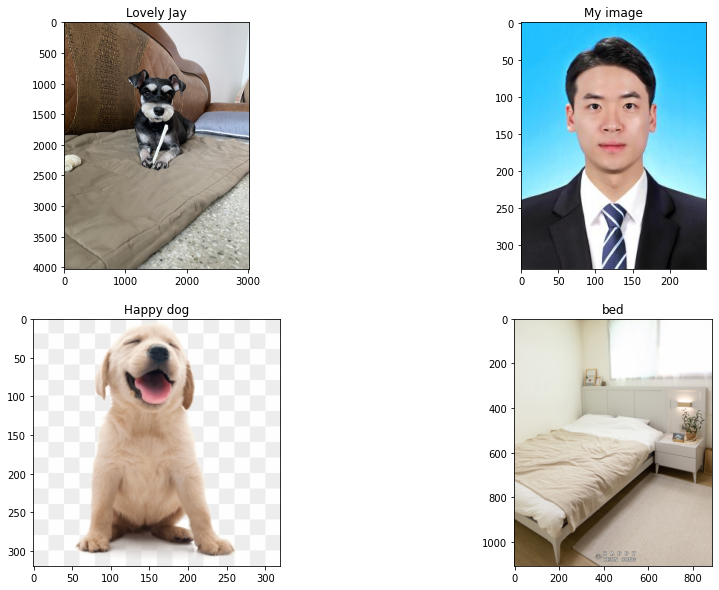

In [3]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(cv2.cvtColor(jay_img_orig, cv2.COLOR_BGR2RGB))
plt.title('Lovely Jay')

plt.subplot(222)
plt.imshow(cv2.cvtColor(my_img_orig, cv2.COLOR_BGR2RGB))
plt.title('My image')

plt.subplot(223)
plt.imshow(cv2.cvtColor(happydog_img_orig, cv2.COLOR_BGR2RGB))
plt.title('Happy dog')

plt.subplot(224)
plt.imshow(cv2.cvtColor(bed_img_orig, cv2.COLOR_BGR2RGB))
plt.title('bed')


plt.show()

#### 이미지 세그멘테이션이란?
- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법, 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 '공통적인 특징'을 가진다고 함.

#### 시맨틱 세그멘테이션이란?
- 세그멘테이션 중 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션
- 즉, 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법

### DeepLab 모델

- 위 사진들을 시멘틱 세그멘테이션 하기위해 DeepLab 모델을 사용하도록 한다.
- `PixelLib`에서 제공해 주는 모델을 다운받는다.

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f5bb58a6fd0>)

`urlretrieve`는 URL로 표시된 네트워크 객체(url 주소의 문서)를 로컬 파일로 저장(직접 다운로드 가능).

**urllib.request.urlretrieved`(url, 로컬에 저장될 파일 이름)`**

다운로드한 모델을 이용해 `PixelLib`로 우리가 사용한 세그멘테이션 모델을 생성한다.

In [5]:
# PASCAL VOC :: Pattern Analysis, Statistical Modeling and Computational Learning / Visual Object Classes
# PASCAL VOC 데이터의 라벨 종류는 다음과 같다.

# background를 제외하면 총 20개의 클래스가 존재한다.

# 이중 사람(person)은 15번, 강아지(dog)는 12번 클래스를 가진다.

label_names = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(label_names)

21

In [6]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### 이제 모델에 이미지를 입력한다.

In [7]:
segvalues, output = model.segmentAsPascalvoc(jay_img_path)

<br>

- `output`에는 세그멘테이션 된 결과가 각각 다른 색상으로 담겨 있다. <br><br>
- `segvalues`는 dict 객체로써 `class_ids'와 'masks' key를 가지고 있다.
<br><br>

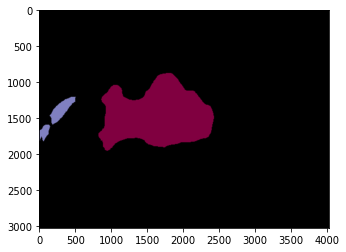

In [11]:
plt.imshow(output)
plt.show()

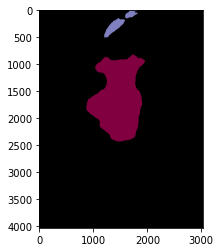

In [9]:
plt.imshow(np.transpose(output, (1,0,2)))
plt.show()

In [15]:
# 이유는 모르겠지만 output 결과가 90도 시계방향으로 회전되어 출력되었다.
# 따라서, pixel 정보를 담은 앞의 두 차원을 Transpose 해주고...
# 이때, 이미지의 좌우 대칭이 일어나게 되는데, numpy의 flip 함수를 써서 보정을 진행해 주었다.

output = np.flip(np.transpose(output, (1,0,2)), 1)

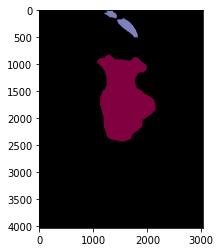

In [16]:
plt.imshow(output)
plt.show()

<br><br>

**`segvalues['mask']` 또한 output과 동일하게 flip 및 Transpose 진행 보정**

<br>

In [65]:
segvalues['masks'] = np.flip(segvalues['masks'].T, 1)

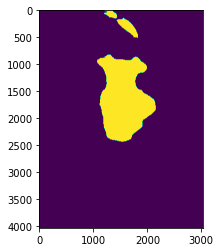

In [72]:
plt.imshow(segvalues['masks'])


In [47]:
for class_id in segvalues['class_ids']:
    print(label_names[class_id])

background
dog
person


---

**여기서 한가지 의문, 유관으로 확인했을 때 사진상에 사람은 존재하지 않는데 모델에서 판단하기로는 사람이 있다고 나온다. <br><br>어떤 부분이 사람을 나타내는지 확인해보자.**


---

<br><br>

### 먼저 물체마다 `output`이 어떤 색상으로 나타나 있는지 알아보자

In [18]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [19]:
# dog를 나타내는 12번째 색상은 무엇일까? 

print(colormap[12]) # dog
print(colormap[15]) # person

[ 64   0 128]
[192 128 128]


여기서, 주의할 점은 `output`이미지가 BGR 순서로 채널 배치되어 있고, `colormap`은 RGB 순서이다.<br>
따라서, 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔줘야 한다.

In [23]:
# seg_color_dog=(128, 0, 64)
seg_color_dog=np.flip(colormap[12])
seg_color_person=np.flip(colormap[15])

print(seg_color_dog)
print(seg_color_person)

[128   0  64]
[128 128 192]


<br>

**이제 `seg_color`로만 이루어진 마스크를 만들어 보자.<br><br>먼저 사람으로 식별된 segmentation을 마스크를 이용해서 나타내본다.<br><br>이후 강아지가 표현된 부분을 나타내본다.**<br><br>

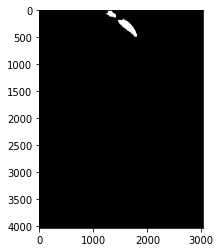

In [25]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.

seg_map_person = np.all(output==seg_color_person, axis=-1)
plt.imshow(seg_map_person, cmap='gray')
plt.show()


(4032, 3024)


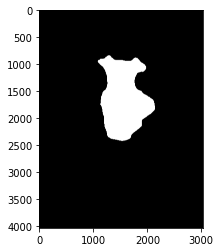

In [26]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.

seg_map_dog = np.all(output==seg_color_dog, axis=-1)
print(seg_map_dog.shape)
plt.imshow(seg_map_dog, cmap='gray')
plt.show()


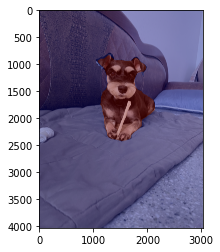

In [28]:
jay_img_show = jay_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map_dog.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
# jay_img_show = cv2.addWeighted(np.transpose(jay_img_show, (1,0,2)), 0.6, color_mask, 0.4, 0.0)
jay_img_show = cv2.addWeighted(jay_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(jay_img_show, cv2.COLOR_BGR2RGB))
plt.show()



### 이번에는 배경을 흐리게 만들어보자 
- `blur()`함수를 이용한다.

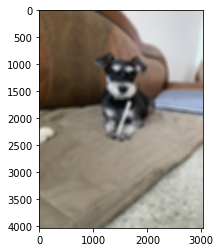

In [39]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(jay_img_orig, (80,80))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

<br>**위의 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출해보자<br><br>0~255 숫자 중 255가 흰색을 나타낸다.<br><br>**

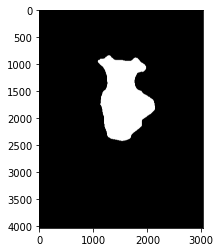

In [40]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
plt.imshow(img_mask_color)

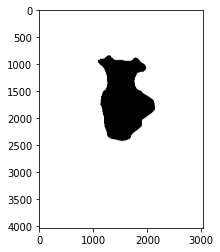

In [41]:
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(img_bg_mask)

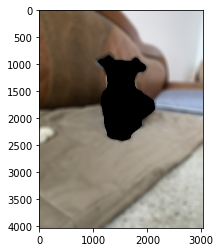

In [42]:
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- `bitwise_not` 함수를 사용하면 이미지 반전이 이러난다. 원래 마스크에서 배경이 0, 강아지가 255였으니, `bitwise_not`연산을 하고 나면 배경이 255, 강아지가 0이 된다.

- 반전된 세그멘테이션 결과를 이용해서 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 

### 흐린 배경과 원본 영상 합성하기

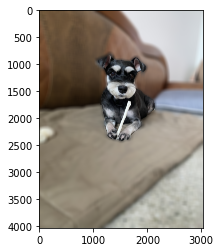

In [47]:
img_concat = np.where(img_mask_color==255, jay_img_orig, img_bg_blur)
img_concat_RGB = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
# plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.imshow(img_concat_RGB)
plt.show()

<br>

# Step2. 사진에서 문제점 찾기

---

**PIL은 파이썬에서 이미지 분석 및 처리를 쉽게 할 수 있는 라이브러리이다.<br><br>다양한 이미지 파일 형식을 지원하며 다양한 이미지 처리와 그래픽 기능을 제공한다.<br><br>**

In [46]:
from PIL import Image

In [50]:
img_concat_RGB.shape

(4032, 3024, 3)

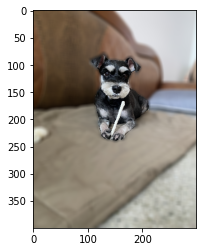

In [55]:
img_concat_RGB_reshape = cv2.resize(img_concat_RGB, (300,400), interpolation=cv2.INTER_LINEAR)
plt.imshow(img_concat_RGB_reshape)

In [57]:
# im = Image.fromarray(img_concat_RGB_reshape)
im = Image.fromarray(img_concat_RGB)
im.save('img_concat_RGB.png', format='png')

<img src="https://user-images.githubusercontent.com/103712369/172662589-8f9c9392-6635-43c8-b0e5-7d73699fb1d1.png" width="700" height="300">

<!-- ![image](https://user-images.githubusercontent.com/103712369/172662589-8f9c9392-6635-43c8-b0e5-7d73699fb1d1.png) -->

<br>

# Step3. 해결 방법을 제안해보기

---

#### (1) 피사계 심도를 이해하고 Depth를 조절하여 위 문제를 해결할 수 있을까?

- 아웃포커싱, 즉 얕은 피사계 심도는 초점이 맞은 피사체 외의 배경을 흐릿하게 보이도록 하는 기술이다.<br>피사계 심도(depth of field, DOF)는 사진에서 초점이 맞은 것으로 인식되는 범위이다.


- 실제 카메라에서는 아웃포커싱을 만들어내기위해 1) 피사체와의 거리를 조절해야하며 2) 렌즈의 크기나 조리개 개방정도를 조작하여 조도를 조절하여야 한다. 
- 결국 거리와 빛을 조절해서 피사계 심도를 설정한다는 얘기이다. 즉, 이와 같은 방법으로는 위 문제('Stick을 강아지로 마스킹한)를 해결하기 어려울 것으로 판단된다.

#### (2) 소프트웨어 기술 활용해보기

- 기계적인 조작으로는 해당 문제를 해결하기 어려울 것으로 판단이 되었다. <br>따라서 소프트웨어 기술을 적용하여 강아지와 강아지가 아닌 부분을 파악하여야 한다.


- 그렇다면, 어떤 방법으로 가능할 것인가? <br>노드에서 소개하고 있는 구글 pixel4의 IR(적외선) 카메라와 융합하여 위 문제를 해결할 수 있을 것 같다. <br><br>

**적외선 카메라 작동원리**
> 선 카메라는 가시강선을 이용한 일반 카메라와 달리 열을 이용해 이미지를 만들어낸다.<br>
> 에너지를 받아들이고 적외선 에너지의 데이터를 사용하여 디지털 또는 아날로그 영상 출력 기능을 통해 이미지를 만든다.

- 다시 본론으로 돌아와서 적외선 카메라와 융합하면, 1) 먼저 일반적인 카메라를 통해 얕은 피사계 심도를 만들어 내고, 2) 아직 완성도가 높지 않은 이미지를 적외선, 즉 열을 감지하여 강아지의 체온과 stick 체온을 구분하여 이미지에서 강아지만 포함된 부분만 깔끔하게 추출해낼 수 있을 것으로 판단된다.

![image](https://user-images.githubusercontent.com/103712369/172671912-18763e1f-c635-4bb4-8f15-007fda69335e.png)


# 결론

---

- 이번 노드에서는 Semantic Segmentation에 대해서 다루어 보았다. <br>Segmentation이란? 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법이다(노드 내용 中)<br>그렇다면 Semantic Segmentation이란 segmentation에서 조금 더 나아가서 이미지 안에서의 어떤 물리적 단위로 인식되는 객체의 선을 픽셀단위로 추출해내는 것을 말한다.


- 우리는 본 노드에서 PASCAL VOC 데이터를 통해 학습된 DeepLab v3+ 모델을 적용하여 전이학습을 진행하였다.<br><br>
    - `pixellib`(시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리)을 사용였다.
    
    
- Pascal voc 데이터에는 사람뿐만아니라 강아지를 포함하여 총 21개의 Class가 정의되어 있었다.<br>본 프로젝트에서는 우리집 막내 귀염둥이 재이를 적용하여 배경 흐리게 하는 예제를 진행해보았다. 


- 이미 여러 데이터 셋을 통해 검증된 모델이라서 그런지 처음 시도하는 사진에도 한번에 강아지 이미지만을 마스킹하고 깔끔하게 표현되는 것을 볼 수 있었다. 


- 그럼에도 불구하고 완성도가 조금 떨어지는 문제점들에 대해서는 조금 더 보완이 필요할 것으로 판단되며 위에서 제시한 방법등을 적용하여 조금 더 완성도를 높일 수 있지 않을까 싶다.